## Define channel order, module

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf

print(tf.__version__)

2.1.0-rc1


In [0]:
import argparse

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist  # mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import initializers
from tensorflow.keras import backend as K


K.set_image_data_format('channels_first')

## Define Dataset

In [4]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, batch_size, z_input_dim):
        # load mnist dataset
        # 이미지는 보통 -1~1 사이의 값으로 normalization : generator의 outputlayer를 tanh로
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        self.x_data = ((X_train.astype(np.float32) - 127.5) / 127.5)
        self.x_data = self.x_data.reshape((self.x_data.shape[0], 1) + self.x_data.shape[1:])
        self.batch_size = batch_size
        self.z_input_dim = z_input_dim

    def get_real_sample(self):
        """
        get real sample mnist images

        :return: batch_size number of mnist image data
        """
        return self.x_data[np.random.randint(0, self.x_data.shape[0], size=self.batch_size)]

    def get_z_sample(self, sample_size):
        """
        get z sample data

        :return: random z data (batch_size, z_input_dim) size
        """
        return np.random.uniform(-1.0, 1.0, (sample_size, self.z_input_dim))

data = Data(batch_size=2, z_input_dim=100)
print(data.get_real_sample())
print(data.get_z_sample(2))

11493376/11490434 [==============================] - 0s 0us/step
[[[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]


 [[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]]
[[-0.42012018  0.45413653  0.04773786  0.92600429  0.39079159 -0.58164193
   0.06244761  0.05451634 -0.88898393 -0.33275286 -0.98458637  0.80776397
  -0.89132186 -0.94500125  0.55171243  0.40424056  0.48301902 -0.24235757
  -0.05729991 -0.99280261 -0.24003744  0.4261791   0.89029154  0.90286604
  -0.10809216 -0.29343938 -0.14026997  0.73404863 -0.1016617  -0.64862357
  -0.26373631 -0.18410975 -0.28478093 -0.01671086  0.97311446  0.98740384
  -0.41520365 -0.27896198 -0.26092643 -0.48194884  0.09819973  0.88124125


- Mnist data test

## GAN 모델 정의

- discriminator : CNN 판별기로 모델링
- generator : input Z를 확장한 뒤 CNN 생성기로 모델링

In [0]:
class GAN:
    def __init__(self, learning_rate, z_input_dim):
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.combined()

    def discriminator(self):
        D = Sequential()
        D.add(Conv2D(256, (5, 5),
                     padding='same',
                     input_shape=(1, 28, 28),
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Conv2D(512, (5, 5), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Flatten())
        D.add(Dense(256))
        D.add(LeakyReLU(0.2))
        D.add(Dropout(0.3))
        D.add(Dense(1, activation='sigmoid'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return D

    def generator(self):
        G = Sequential()
        G.add(Dense(512, input_dim=self.z_input_dim))
        G.add(LeakyReLU(0.2))
        G.add(Dense(128 * 7 * 7))
        G.add(LeakyReLU(0.2))
        G.add(BatchNormalization())
        G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return G

    def combined(self):
        G, D = self.G, self.D
        D.trainable = False
        GD = Sequential()
        GD.add(G)
        GD.add(D)

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        GD.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        D.trainable = True
        return GD


## Learner 구성

- discriminator와 generator를 다른 epoch 비율로 학습 가능하도록 구성
- 20 epoch 마다 이미지 생성
- D, G를 각각 학습
- 학습 완료 후 loss graph 생성

In [0]:
class Model:
    def __init__(self, batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.data = Data(self.batch_size, self.z_input_dim)

        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D
        self.n_iter_G = n_iter_G
        self.gan = GAN(self.learning_rate, self.z_input_dim)

        # print status
        batch_count = self.data.x_data.shape[0] / self.batch_size
        print('Epochs:', self.epochs)
        print('Batch size:', self.batch_size)
        print('Batches per epoch:', batch_count)
        print('Learning rate:', self.learning_rate)
        print('Image data format:', K.image_data_format())

    def fit(self):
        self.d_loss = []
        self.g_loss = []
        for epoch in range(self.epochs):

            # train discriminator by real data
            dloss = 0
            for iter in range(self.n_iter_D):
                dloss = self.train_D()

            # train GD by generated fake data
            gloss = 0
            for iter in range(self.n_iter_G):
                gloss = self.train_G()

            # save loss data
            self.d_loss.append(dloss)
            self.g_loss.append(gloss)

            # plot and save model each 20n epoch
            if epoch % 20 == 0:
                self.plot_generate_images(epoch, self.gan.G, examples=8)
                print('Epoch:', str(epoch))
                print('Discriminator loss:', str(dloss))
                print('Generator loss:', str(gloss))
        
        # show loss after train
        self.plot_loss_graph(self.g_loss, self.d_loss)

    def train_D(self):
        # Real data
        real = self.data.get_real_sample()

        # Generated data
        z = self.data.get_z_sample(self.batch_size)
        generated_images = self.gan.G.predict(z)

        # labeling and concat generated, real images
        x = np.concatenate((real, generated_images), axis=0)
        y = [0.9] * self.batch_size + [0] * self.batch_size

        # train discriminator
        self.gan.D.trainable = True
        loss = self.gan.D.train_on_batch(x, y)
        return loss

    def train_G(self):
        # Generated data
        z = self.data.get_z_sample(self.batch_size)

        # labeling
        y = [1] * self.batch_size

        # train generator
        self.gan.D.trainable = False
        loss = self.gan.GD.train_on_batch(z, y)
        return loss

    def plot_loss_graph(self, g_loss, d_loss):
        """
        Save training loss graph
        """

        # show loss graph
        plt.figure(figsize=(10, 8))
        plt.plot(d_loss, label='Discriminator loss')
        plt.plot(g_loss, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_generate_images(self, epoch, generator, examples=8):
        """
        Save generated mnist images
        """
        # plt info
        dim = (10, 10)
        figsize = (10, 10)

        # generate images
        z = self.data.get_z_sample(examples)
        generated_images = generator.predict(z)

        # show images
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i].reshape((28, 28)), interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()


## 학습 진행

Epochs: 1000
Batch size: 128
Batches per epoch: 468.75
Learning rate: 0.0002
Image data format: channels_first


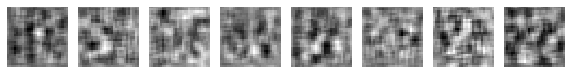

Epoch: 0
Discriminator loss: [0.673771, 0.1015625]
Generator loss: [0.045520235, 1.0]


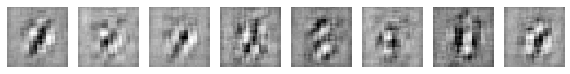

Epoch: 20
Discriminator loss: [0.4765095, 0.4765625]
Generator loss: [0.22998634, 1.0]


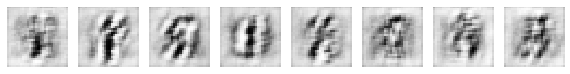

Epoch: 40
Discriminator loss: [0.71233433, 0.0]
Generator loss: [1.009002, 0.0]


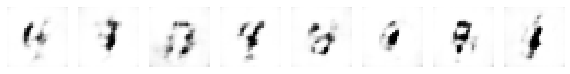

Epoch: 60
Discriminator loss: [0.5070108, 0.5]
Generator loss: [0.64933634, 0.7265625]


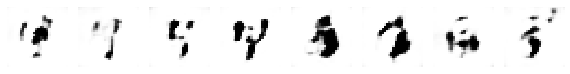

Epoch: 80
Discriminator loss: [0.8395364, 0.0]
Generator loss: [1.6908762, 0.0]


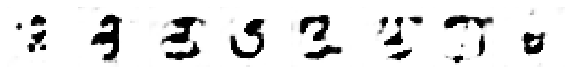

Epoch: 100
Discriminator loss: [0.63167816, 0.38671875]
Generator loss: [1.1896236, 0.0]


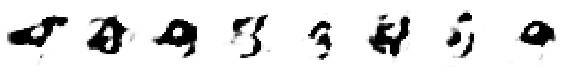

Epoch: 120
Discriminator loss: [0.49172345, 0.4765625]
Generator loss: [1.1755464, 0.1015625]


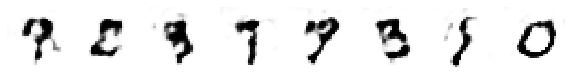

Epoch: 140
Discriminator loss: [0.5833329, 0.3515625]
Generator loss: [1.5832933, 0.015625]


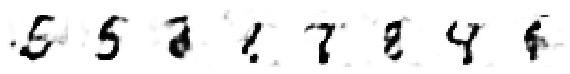

Epoch: 160
Discriminator loss: [0.6288518, 0.49609375]
Generator loss: [0.8692396, 0.203125]


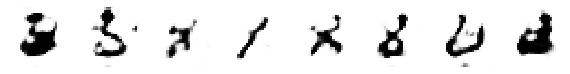

Epoch: 180
Discriminator loss: [0.5983155, 0.3515625]
Generator loss: [0.7002527, 0.5]


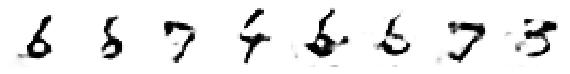

Epoch: 200
Discriminator loss: [0.60325825, 0.48828125]
Generator loss: [0.74964124, 0.4609375]


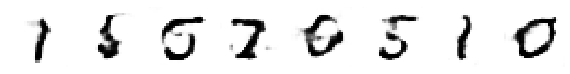

Epoch: 220
Discriminator loss: [0.6567106, 0.453125]
Generator loss: [0.82817495, 0.265625]


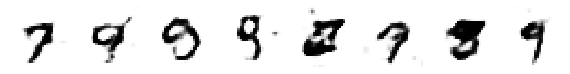

Epoch: 240
Discriminator loss: [0.59017086, 0.33984375]
Generator loss: [0.8799896, 0.2421875]


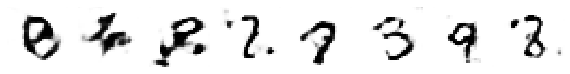

Epoch: 260
Discriminator loss: [0.63321793, 0.36328125]
Generator loss: [0.8186593, 0.28125]


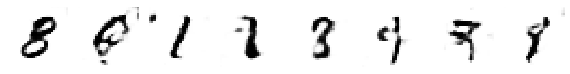

Epoch: 280
Discriminator loss: [0.6334658, 0.48828125]
Generator loss: [0.91574955, 0.0625]


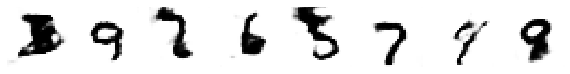

Epoch: 300
Discriminator loss: [0.6160922, 0.44921875]
Generator loss: [0.9771683, 0.109375]


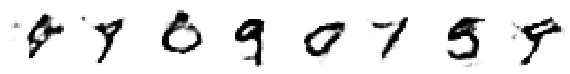

Epoch: 320
Discriminator loss: [0.6218604, 0.44921875]
Generator loss: [0.9264629, 0.1875]


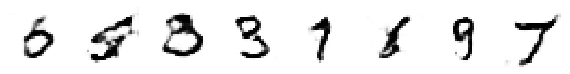

Epoch: 340
Discriminator loss: [0.6245622, 0.45703125]
Generator loss: [0.95211893, 0.125]


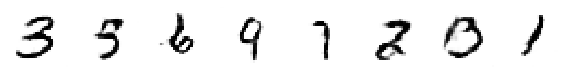

Epoch: 360
Discriminator loss: [0.69296074, 0.49609375]
Generator loss: [0.48844492, 0.8359375]


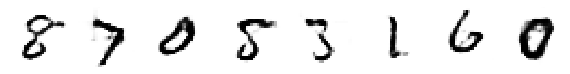

Epoch: 380
Discriminator loss: [0.6301851, 0.40234375]
Generator loss: [0.9792373, 0.0703125]


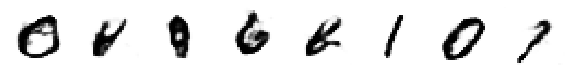

Epoch: 400
Discriminator loss: [0.6543803, 0.328125]
Generator loss: [1.1202183, 0.0234375]


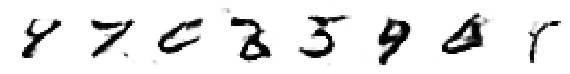

Epoch: 420
Discriminator loss: [0.6520821, 0.40234375]
Generator loss: [0.8539083, 0.1953125]


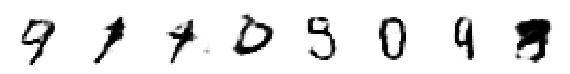

Epoch: 440
Discriminator loss: [0.67650867, 0.46875]
Generator loss: [0.79001653, 0.3046875]


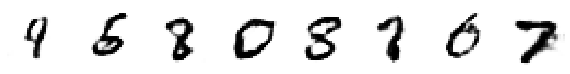

Epoch: 460
Discriminator loss: [0.6466994, 0.43359375]
Generator loss: [0.7587951, 0.40625]


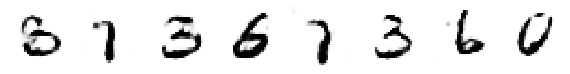

Epoch: 480
Discriminator loss: [0.6816676, 0.1484375]
Generator loss: [0.7618085, 0.34375]


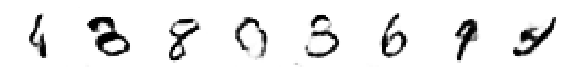

Epoch: 500
Discriminator loss: [0.634817, 0.34375]
Generator loss: [1.0561635, 0.0390625]


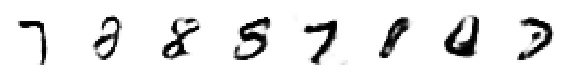

Epoch: 520
Discriminator loss: [0.636608, 0.421875]
Generator loss: [0.9269619, 0.109375]


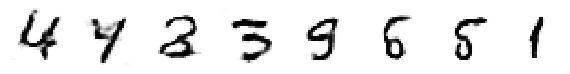

Epoch: 540
Discriminator loss: [0.6712327, 0.4609375]
Generator loss: [0.838035, 0.2109375]


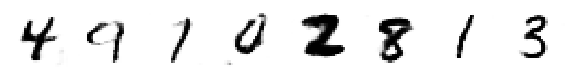

Epoch: 560
Discriminator loss: [0.65979433, 0.4921875]
Generator loss: [0.7643331, 0.328125]


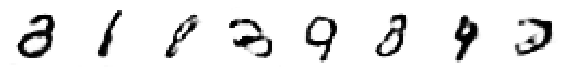

Epoch: 580
Discriminator loss: [0.66276145, 0.265625]
Generator loss: [0.9151715, 0.125]


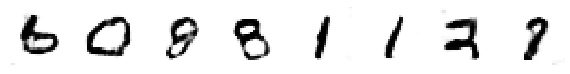

Epoch: 600
Discriminator loss: [0.6836735, 0.45703125]
Generator loss: [0.7872297, 0.21875]


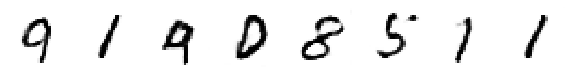

Epoch: 620
Discriminator loss: [0.67242235, 0.44921875]
Generator loss: [0.7427008, 0.4140625]


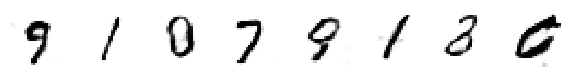

Epoch: 640
Discriminator loss: [0.65630424, 0.49609375]
Generator loss: [0.62854385, 0.640625]


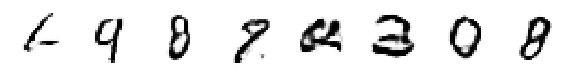

Epoch: 660
Discriminator loss: [0.6559214, 0.44921875]
Generator loss: [0.81904465, 0.21875]


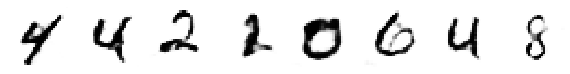

Epoch: 680
Discriminator loss: [0.67749095, 0.33984375]
Generator loss: [0.8851758, 0.1953125]


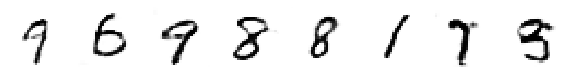

Epoch: 700
Discriminator loss: [0.67854303, 0.4921875]
Generator loss: [0.7075112, 0.46875]


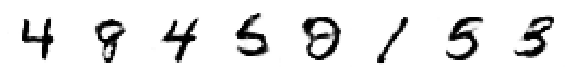

Epoch: 720
Discriminator loss: [0.66408587, 0.4140625]
Generator loss: [0.8975798, 0.1171875]


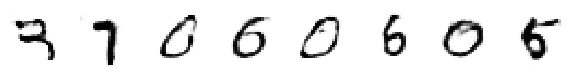

Epoch: 740
Discriminator loss: [0.69367415, 0.41796875]
Generator loss: [0.9687289, 0.09375]


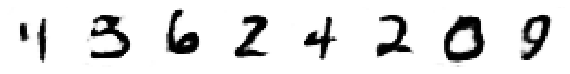

Epoch: 760
Discriminator loss: [0.67900074, 0.45703125]
Generator loss: [0.8675902, 0.125]


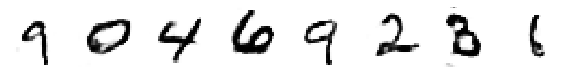

Epoch: 780
Discriminator loss: [0.6928596, 0.4921875]
Generator loss: [0.67761654, 0.5546875]


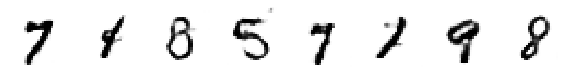

Epoch: 800
Discriminator loss: [0.65392554, 0.3828125]
Generator loss: [1.0199313, 0.0234375]


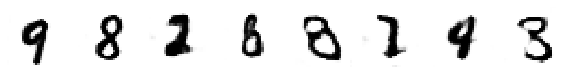

Epoch: 820
Discriminator loss: [0.6674276, 0.26171875]
Generator loss: [1.0156969, 0.046875]


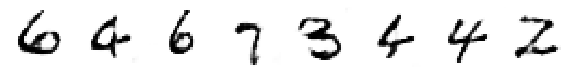

Epoch: 840
Discriminator loss: [0.6540904, 0.390625]
Generator loss: [0.9293162, 0.1640625]


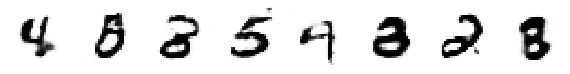

Epoch: 860
Discriminator loss: [0.66117823, 0.30078125]
Generator loss: [0.96083283, 0.0859375]


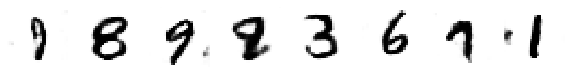

Epoch: 880
Discriminator loss: [0.7542158, 0.5]
Generator loss: [0.64934444, 0.59375]


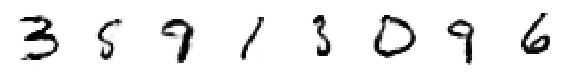

Epoch: 900
Discriminator loss: [0.6668457, 0.40234375]
Generator loss: [0.99845123, 0.1015625]


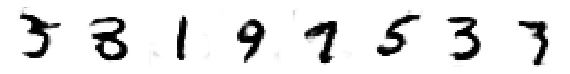

Epoch: 920
Discriminator loss: [0.6995989, 0.49609375]
Generator loss: [0.7863517, 0.1875]


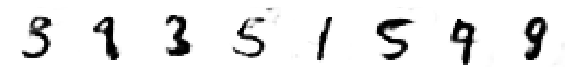

Epoch: 940
Discriminator loss: [0.6545477, 0.3671875]
Generator loss: [0.8249699, 0.203125]


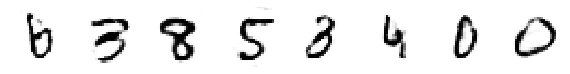

Epoch: 960
Discriminator loss: [0.6468277, 0.484375]
Generator loss: [0.7584284, 0.3203125]


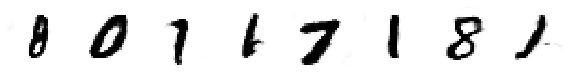

Epoch: 980
Discriminator loss: [0.6383392, 0.4453125]
Generator loss: [0.8000915, 0.2421875]


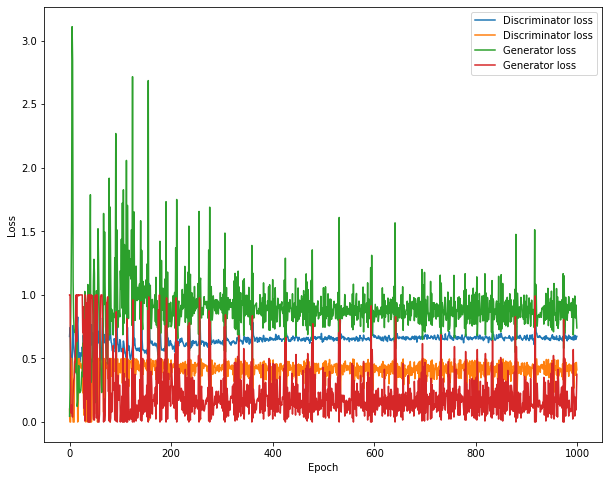

In [7]:
def main():
    # set hyper parameters    
    batch_size = 128
    epochs = 1001
    learning_rate = 0.0002
    z_input_dim = 100
    n_iter_D = 1
    n_iter_G = 5

    # run model
    model = Model(batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G)
    model.fit()


if __name__ == '__main__':
    main()

## 참고 : 모델 시각화

In [11]:
!apt-get install graphviz
!pip install -q pydot
!pip install graphviz


from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


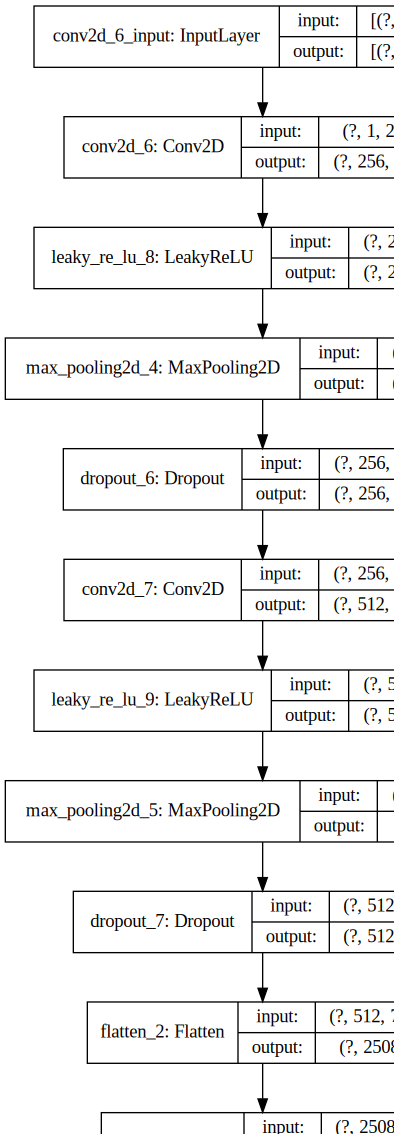

In [12]:
D = Sequential()
D.add(Conv2D(256, (5, 5),
         padding='same',
         input_shape=(1, 28, 28),
         kernel_initializer=initializers.RandomNormal(stddev=0.02)))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Conv2D(512, (5, 5), padding='same'))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Flatten())
D.add(Dense(256))
D.add(LeakyReLU(0.2))
D.add(Dropout(0.3))
D.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0002, beta_1=0.5)
D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(D, show_shapes=True).create(prog='dot', format='svg'))

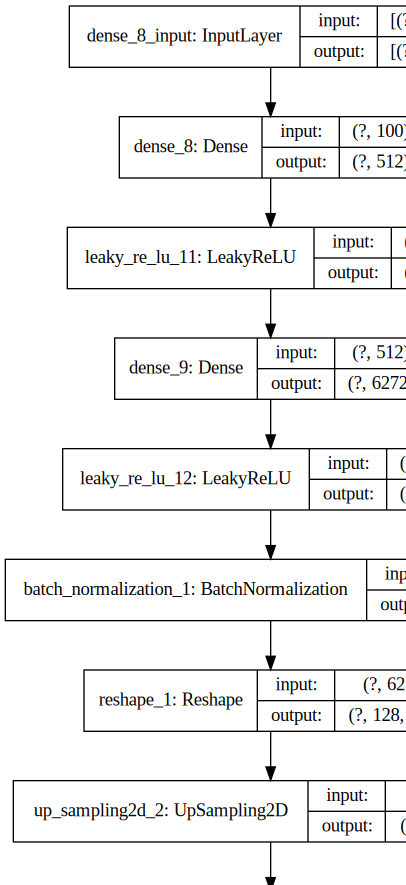

In [13]:
G = Sequential()
G.add(Dense(512, input_dim=100))
G.add(LeakyReLU(0.2))
G.add(Dense(128 * 7 * 7))
G.add(LeakyReLU(0.2))
G.add(BatchNormalization())
G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

adam = Adam(lr=0.0002, beta_1=0.5)
G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(G, show_shapes=True).create(prog='dot', format='svg'))